# **Imports**

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output as cls

!pip install tf_explain

# For formatting
cls()

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Data 
from tqdm import tqdm
from tensorflow.keras.utils import load_img, img_to_array
import glob
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

# Data Visulization
import matplotlib.pyplot as plt

# Model Layers
from keras.models import Model
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, ReLU
from keras.models import Sequential

# Backbone
from tensorflow.keras.applications import ResNet50

# Model Architecture Visualization
from tensorflow.keras.utils import plot_model

# Optimizer
from tensorflow.keras.optimizers import Adam

# Callbacks
from keras.callbacks import ModelCheckpoint, Callback

# Model Layer Visualization
from tf_explain.core.grad_cam import GradCAM

# **Data Loading**

In [ ]:
# Specify paths
root_path = '/content/drive/MyDrive/floodddss_deeplabv3/'
image_path = '/content/drive/MyDrive/floodddss_deeplabv3/Image/'
mask_path = '/content/drive/MyDrive/floodddss_deeplabv3/Mask/'
metadata_path = '/content/drive/MyDrive/floodddss_deeplabv3/metadata.csv'

In [ ]:
# Load file
metadata = pd.read_csv(metadata_path)

# Show
metadata

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png
...,...,...
285,1083.jpg,1083.png
286,1084.jpg,1084.png
287,1085.jpg,1085.png
288,1086.jpg,1086.png


In [ ]:
# This is a helper function
def load_image(path:str, SIZE:tuple = (256, 256), mask:bool = False):
       
    # load Image
    image = load_img(path)
    
    # Convert to an array
    image = img_to_array(image)
    
    # Resize the image
    image = tfi.resize(image, SIZE)
    
    # Convert to Tensor of 32Bit - Float
    image = tf.cast(image, tf.float32)
    
    # Normalize the image
    image = image/255.
    
    # Mask
    if mask:
        image = image[:, :, :1]
        
    # return image
    return image

In [ ]:
def load_data(root_path:str=root_path):
    
    # Load the Image and Mask paths
    image_paths = sorted(glob(root_path + "Image/*.jpg"))
    mask_paths  = [path.replace("Image", "Mask").replace("jpg", "png") for path in image_paths]
    
    # Create space for loading the images and masks
    images = np.empty(shape=(len(image_paths), 256, 256, 3), dtype=np.float32)
    masks  = np.empty(shape=(len(image_paths), 256, 256, 1), dtype=np.float32)
    
    # load the images and masks
    for i, (img_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):

        # Load the image
        image = load_image(path = img_path, mask = False)
        
        # Load the respective mask
        mask  = load_image(path = mask_path, mask = True)
        
        # Put this into the Space
        images[i] = image
        masks[i]  = mask
    
    # Return the images and Masks
    return images, masks

In [ ]:
# Colect All images and masks 
all_images, all_masks = load_data(root_path)

Loading: 290it [01:34,  3.07it/s]


In [ ]:
# Split data into Training and Testing
data_len = len(all_images)

# Training set
train_images, train_masks = all_images[:int(data_len*0.8)], all_masks[:int(data_len*0.8)]

# Testing Set
test_images,  test_masks = all_images[int(data_len*0.8):], all_masks[int(data_len*0.8):]

# **Data Visualization**

In [ ]:
def show_images(images, masks, n_images, SIZE=(15,8)) -> None:
    
    # Plot n Images
    for i in range(n_images):

        # Plotting Configuration
        plt.figure(figsize=SIZE)
    
        # Select a image Randomly
        id = np.random.randint(len(images))
        
        # Plot the Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[id])
        plt.title("Image")
        plt.axis('off')
        
        # Plot the Mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[id], cmap='gray')
        plt.title("Mask")
        plt.axis('off')
        
        # Plot the Overlapping Mask
        plt.subplot(1, 3, 3)
        plt.imshow(images[id], cmap='gray')
        plt.imshow(masks[id], cmap='gray', alpha=0.5)
        plt.title("Overlapping Mask")
        plt.axis('off')
        
        # Shwo a Single Frame : This is done to speed up plotting for large number images
        plt.tight_layout()
        plt.show()

In [ ]:
show_images(train_images, train_masks, n_images=10)

Output hidden; open in https://colab.research.google.com to view.

# **DeepLabV3+**

In [ ]:
class ConvBlock(Layer):
      
    def __init__(self, filters:int = 256, kernel_size:int = 3, dilation_rate:int = 1, **kwargs) -> None:
        super(ConvBlock, self).__init__(**kwargs)
        
        # Define Parameters
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        
        # Define the model 
        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, padding='same', strides=1, dilation_rate=dilation_rate, activation=None, use_bias=False),
            BatchNormalization(),
            ReLU()
        ])
    
    def call(self, X):
        # Apply the layers
        return self.net(X)
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "dilation_rate":self.dilation_rate
        }

In [ ]:
def AtrousSpatialPyramidPooling(X):
    
    # Shape
    _, H, W, C = X.shape
    
    # Image Pooling 
    image_pool = AveragePooling2D(pool_size=(H, W), name="ASPP-ImagePool-AP")(X)
    image_pool = ConvBlock(kernel_size=1, name="ASPP-ImagePool-CB")(image_pool)
    image_pool = UpSampling2D(size=(H//image_pool.shape[1], W//image_pool.shape[1]), name="ASPP-ImagePool-US")(image_pool)
    
    # Astrous Layers
    conv_1  = ConvBlock(kernel_size=1, dilation_rate=1, name="ASPP-Conv1")(X)
    conv_6  = ConvBlock(kernel_size=3, dilation_rate=6, name="ASPP-Conv6")(X)
    conv_12 = ConvBlock(kernel_size=3, dilation_rate=12, name="ASPP-Conv12")(X)
    conv_18 = ConvBlock(kernel_size=3, dilation_rate=18, name="ASPP-Conv18")(X)
    
    # Combine All
    combined = Concatenate(name="ASPP-Concatenate")([image_pool, conv_1, conv_6, conv_12, conv_18])
    output = ConvBlock(kernel_size=1, name="ASPP-Out")(combined)
    
    return output

In [ ]:
# Model Specifications
IMAGE_SIZE = 256
MODEL_NAME = "DeepLab-FloodArea"

# Input Layer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")

# Backbone
backbone = ResNet50(input_tensor=inputs, weights='imagenet', include_top=False)

# High Level Features
DCNN = backbone.get_layer('conv4_block6_2_relu').output
ASPP = AtrousSpatialPyramidPooling(DCNN)
ASPP = UpSampling2D(size=(
    IMAGE_SIZE//4//ASPP.shape[1], IMAGE_SIZE//4//ASPP.shape[2]
), name="ASPP-UpSample-Out")(ASPP)

# Low Level Features
LLF = backbone.get_layer('conv2_block3_2_relu').output
LLF = ConvBlock(filters=48, kernel_size=1, name="LLF-ConvBlock")(LLF)

# Combine
concat = Concatenate(axis=-1, name="Concat-LLF-HLF")([LLF, ASPP])
y = ConvBlock(name="TopConvBlock1")(concat)
y = ConvBlock(name="TopConvBlock2")(y)
y = UpSampling2D(size=(
    IMAGE_SIZE//y.shape[1], IMAGE_SIZE//y.shape[2]
), name="Feature-UpSample")(y)

# Output Layer
output = Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid', use_bias=False, name="OutputLayer")(y)

# Model
DeepLabV3 = Model(inputs, output, name=MODEL_NAME)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
DeepLabV3.summary()

Model: "DeepLab-FloodArea"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['InputLayer[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

# **DeepLabV3+ Visualization**

In [ ]:
plot_model(DeepLabV3, MODEL_NAME+".png", dpi=96, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

# **Model Callback**

In [ ]:
class ShowProgress(Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%10==0:
            show_model_preds(test_images, test_masks, self.model)

In [ ]:
# Compile
DeepLabV3.compile(
    loss='binary_crossentropy',
    optimizer="adam"
)

# Callbacks
callbacks = [
    ModelCheckpoint(MODEL_NAME+".h5", save_best_only=True),
    ShowProgress()
]

# Train
history = DeepLabV3.fit(
    train_images, train_masks,
    validation_data=(test_images, test_masks),
    epochs=1,
    callbacks=callbacks,
    batch_size=8,
)


20/29 [===================>..........] - ETA: 3:36 - loss: 0.5156

# **Model Predictions**

In [ ]:
import os
import torch
import torchvision

# Define the model
model = history

# Define the file path to save the model
dir_path = "C:\\Users\\Rishi\\Desktop\\"
os.makedirs(dir_path, exist_ok=True)
file_path = os.path.join(dir_path, "deeplabv3_model.pth")

# Save the model
torch.save(model, file_path)

# file_path = "C:\\Users\\Rishi\\Desktop\\Home\\deeplabv3_model.pth"

# # Load the saved model parameters into the model
# model.load(torch.load(file_path))

In [ ]:
# from tensorflow.keras.models import load_model
DeepLabV3.save("/content/drive/MyDrive/mini_model")
# Load the model from the saved file
# model = load_model(r"/content/C:\Users\Rishi\Desktop\/deeplabv3_model.pth")

In [ ]:
model.save_weights("/content/drive/MyDrive/mini_model")

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/mini_model/model.h5')

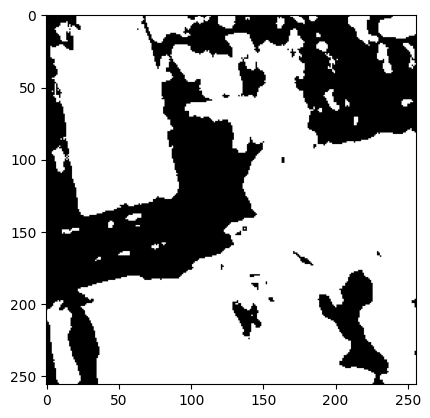

[[21567 10902]
 [  861 32206]]
Accuracy:  0.8205108642578125
Precision:  0.6642335766423357
Recall:  0.9616104868913857
F-Score:  0.7857259959560632
Elapsed time: 1.681 seconds


In [ ]:
# for i in range(20):
#     show_model_preds(test_images, test_masks, model=DeepLabV3, SIZE=(25,8))
# displaying random image, mask, and predicted mask
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow.image as tfi
import numpy as np
import time
import os
from sklearn.metrics import confusion_matrix
from IPython.display import Image
start_time = time.time()

###
image = load_img('/content/drive/MyDrive/floodddss_deeplabv3/Image/3098.jpg')
img = tfi.resize(image, (256,256))
predMask = model.predict(np.expand_dims(img, axis=0), verbose=0)
# Apply a threshold to the predicted mask
threshold = 0.5
predMask[predMask < threshold] = 0
predMask[predMask >= threshold] = 1

mask = np.squeeze(predMask)
mask = np.stack((mask,)*3, axis=-1)
mask = np.where(mask==1, 255, 0)

# Show the image
plt.imshow(mask)
plt.show()

# plt.imshow(np.squeeze(predMask))
# plt.show()

# Load the ground truth mask
maskFile = os.path.splitext('/content/drive/MyDrive/floodddss_deeplabv3/Mask/3098.jpg')[0] + ".png"
gtMask = cv2.imread(maskFile, cv2.IMREAD_GRAYSCALE)

# Check if the ground truth mask was loaded successfully
if gtMask is None:
    raise ValueError("Failed to load ground truth mask from file {}".format(maskFile))

gtMask = cv2.resize(gtMask, (256, 256), interpolation=cv2.INTER_NEAREST)
# Apply a threshold to the ground truth mask
gtMask[gtMask < 128] = 0
gtMask[gtMask >= 128] = 1

# Compute the confusion matrix
cm = confusion_matrix(gtMask.flatten(), predMask.flatten())

# Print the confusion matrix
print(cm)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
accuracy = (tp+tn)/(tp+fp+tn+fn)
precision = (tp)/(tp+fp)
recall = (tp)/(tp+fn)
fscore = (2*precision*recall)/(precision+recall)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F-Score: ", fscore)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.3f} seconds")
